<a href="https://colab.research.google.com/github/sjunc/AI-Library/blob/main/class/W03_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN CIFAR-10

100%|██████████| 170M/170M [00:02<00:00, 70.0MB/s]


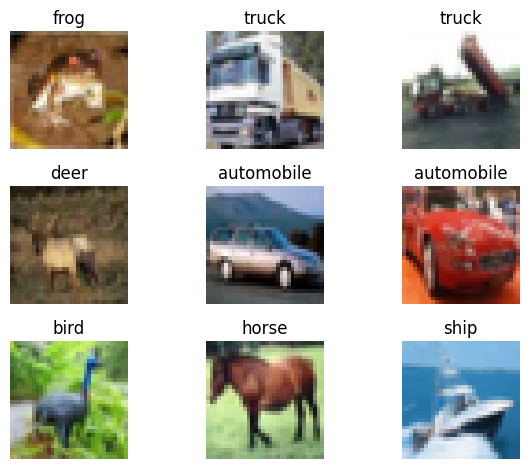

In [1]:
import matplotlib.pyplot as plt

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor     # pytorch tensor로 변환을 위해 import

#CIFAR10 데이터셋을 불러옴
training_data = CIFAR10(
    root="./",#현재 디렉토리에 데이터셋을 불러옴
    train=True,
    download=True,
    transform=ToTensor() )#이미지를 파이토치 텐서로 변환해줌

test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=ToTensor())

# 레이블 확인하기
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(training_data.data[i])
    plt.title(training_data.classes[training_data.targets[i]])#label 표시
    plt.axis('off')  # 축 안 보이게
plt.tight_layout()
plt.show()

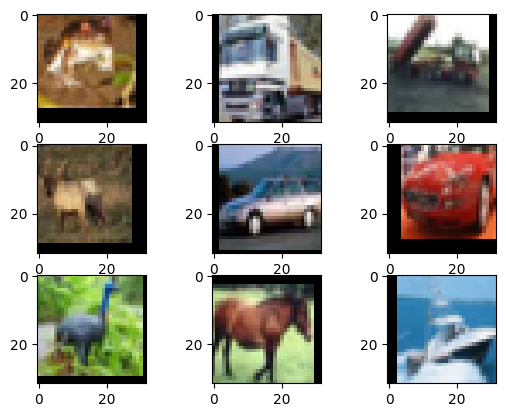

In [2]:
#데이터 증강

import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

transforms = Compose([ #데이터 전처리 함수들
   T.ToPILImage(), # numpy → PIL 이미지로 변환
   RandomCrop((32, 32), padding=4), # 4픽셀 패딩 후 32x32로 랜덤 자르기
   RandomHorizontalFlip(p=0.5),     #y축으로 기준으로 대칭, 50% 확률로
])

training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=transforms) # transform에는 데이터를 변환하는 함수가 들어감

test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=transforms)

for i in range(9):
   plt.subplot(3, 3, i+1)
   plt.imshow(transforms(training_data.data[i]))
plt.show()

In [3]:
import torch

#이미지 정규화를 하기 위한 사전 작업

training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=ToTensor())

# item[0]은 이미지, item[1]은 정답 레이블 -> 이미지만 추출
imgs = [item[0] for item in training_data]

# imgs를 하나로 합침
imgs = torch.stack(imgs, dim=0).numpy()

# rgb 각각의 평균
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r,mean_g,mean_b)

# rgb 각각의 표준편차
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r,std_g,std_b)

0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


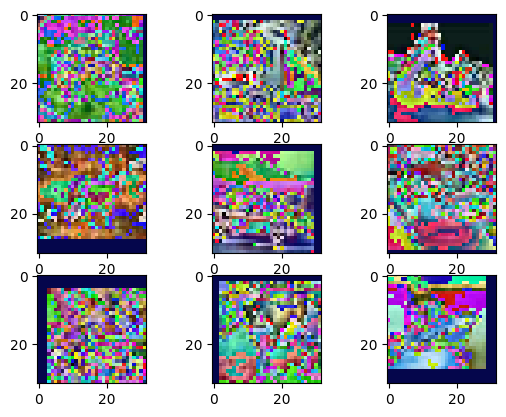

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize

transforms = Compose([
   T.ToPILImage(),
   RandomCrop((32, 32), padding=4),
   RandomHorizontalFlip(p=0.5),
   T.ToTensor(),# PIL 이미지 → Tensor (0~1 정규화됨)
   #데이터 정규화
   Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),#R, G, B 채널별 정규화(방금 전에 구한 값을 기준으로)
   T.ToPILImage()# 다시 PIL 이미지로 변환해서 plt.imshow()에 보여줄 수 있게 함
])

training_data = CIFAR10(
    root="./",
    train=True,
    download=True,
    transform=transforms)
test_data = CIFAR10(
    root="./",
    train=False,
    download=True,
    transform=transforms)

for i in range(9):
   plt.subplot(3, 3, i+1)
   plt.imshow(transforms(training_data.data[i]))
plt.show()

In [5]:
import torch
import torch.nn as nn


#기본 블록: Conv2d → ReLU → Conv2d → ReLU → MaxPool

class BasicBlock(nn.Module): #기본 블록을 정의함. -> 큰 네트워크의 구성 요소
   # 기본블록을 구성하는 계층의 정의
   def __init__(self, in_channels, out_channels, hidden_dim):
       #nn.Module 클래스의 요소 상속
       super(BasicBlock, self).__init__()

       #합성곱층 정의
       self.conv1 = nn.Conv2d(in_channels, hidden_dim,
                              kernel_size=3, padding=1)
       self.conv2 = nn.Conv2d(hidden_dim, out_channels,
                              kernel_size=3, padding=1)
       self.relu = nn.ReLU()

       # stride는 커널의 이동 거리를 의미합니다.
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

   def forward(self, x): #기본블록의 순전파 정의
       x = self.conv1(x)
       x = self.relu(x)
       x = self.conv2(x)
       x = self.relu(x)
       x = self.pool(x)

       return x#기본 블록을 통과한 최종 결

In [6]:
#입력 이미지 → 기본블록 1 → 기본블록 2 → 기본블록 3 → Flatten → FC1 (Fully Connected Layer) → ReLU → FC2 → ReLU → FC3 → 최종 클래스 예측


class CNN(nn.Module):
   def __init__(self, num_classes): # num_classes는 클래스의 개수를 의미합니다: 10
       super(CNN, self).__init__()

       #합성곱 기본 블록의 정의
       #각 블록마다 채널의 수가 늘어나고, maxPool 거치면서 feature map 크기가 절반씩 줄어듦
       self.block1 = BasicBlock(in_channels=3, out_channels=32, hidden_dim=16)
       self.block2 = BasicBlock(in_channels=32, out_channels=128, hidden_dim=64)
       self.block3 = BasicBlock(in_channels=128, out_channels=256, hidden_dim=128)

       #분류기 정의
       self.fc1 = nn.Linear(in_features=4096, out_features=2048)
       self.fc2 = nn.Linear(in_features=2048, out_features=256)
       self.fc3 = nn.Linear(in_features=256, out_features=num_classes)

       #분류기의 활성화 함수
       self.relu = nn.ReLU()

   def forward(self, x):
       x = self.block1(x)
       x = self.block2(x)
       x = self.block3(x)  # 출력 모양: (-1, 256, 4, 4)
       x = torch.flatten(x, start_dim=1) #2차원 특징맵을 1차원으로

       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
       x = self.relu(x)
       x = self.fc3(x)

       return x

In [7]:
from torch.utils.data.dataloader import DataLoader

from torch.optim.adam import Adam

train_transforms = Compose([
   RandomCrop((32, 32), padding=4),  #주변에 4픽셀 추가한 후, 32*32 크기로 랜덤 크롭핑
   RandomHorizontalFlip(p=0.5),  #50% 확률로 y축으로 뒤집기
   ToTensor(),  #텐서로 변환(픽셀값 범위를 정규화함)
   #이미지 정규화(R, G, B 각 채널별)
   Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

In [8]:
test_transform = Compose([
    ToTensor(),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

In [9]:
#학습 데이터와 평가 데이터 불러오기
#transform = transforms 사용하면서 데이터의 증강이 적용됨.
#실제 저장공간에서의 데이터 수가 늘어나나? no. 하지만 매 epoch에서 랜덤한 변화가 생기면서 다양한 모습의 데이터를 볼 수 있음.
training_data = CIFAR10(root="./", train=True, download=True, transform=train_transforms)

#test데이터는 평가용이므로, 원본 데이터로 측정해야 함.
test_data = CIFAR10(root="./", train=False, download=True, transform=test_transform)


#데이터로더 정의
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


#학습을 진행할 프로세서 설정
device = "cuda" if torch.cuda.is_available() else "cpu"


#CNN 모델 정의
model = CNN(num_classes=10)

#모델을 device로 보냄
model.to(device)

CNN(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): BasicBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256,

In [12]:
#학습률 정의
lr = 1e-3

#최적화 기법 정의
optim = Adam(model.parameters(), lr=lr)

# 학습 루프 정의
for epoch in range(100):#시간관계상 1
   for data, label in train_loader:  #데이터 호출
       optim.zero_grad()  #기울기 초기화

       preds = model(data.to(device))  #모델의 예측

       #오차역전파와 최적화
       loss = nn.CrossEntropyLoss()(preds, label.to(device))
       loss.backward()#오차 역전파
       optim.step()#가중치 업데이트

   if epoch==0 or epoch%10==9:  # 10번마다 손실 출력
       print(f"epoch{epoch+1} loss:{loss.item()}")


# 모델 저장
torch.save(model.state_dict(), "CIFAR.pth")

epoch1 loss:0.8923267126083374
epoch10 loss:0.13927654922008514
epoch20 loss:0.24542495608329773
epoch30 loss:0.34498509764671326
epoch40 loss:0.1674596220254898
epoch50 loss:0.40679052472114563
epoch60 loss:1.0850348472595215
epoch70 loss:0.06318458914756775
epoch80 loss:0.6326121091842651
epoch90 loss:0.373582124710083
epoch100 loss:0.32879406213760376


In [13]:
model.load_state_dict(torch.load("CIFAR.pth", map_location=device))

num_corr = 0

with torch.no_grad():#평가시에 연산량 절약하기 위해서 gradient 계산 생략함
   for data, label in test_loader:

       output = model(data.to(device))
       preds = output.data.max(1)[1]#가장 높은 확률의 클래스
       corr = preds.eq(label.to(device).data).sum().item()#정답과 비교하여 맞춘 개수를 셈
       num_corr += corr

   print(f"Accuracy:{num_corr/len(test_data)}")

Accuracy:0.839


# CNN VGG 전이

In [14]:
import torch
import torch.nn as nn

from torchvision.models.vgg import vgg16

device = "cuda" if torch.cuda.is_available() else "cpu"

model = vgg16(pretrained=True) # vgg16 모델 객체 생성, ImageNet 데이터셋으로 이미 학습된 것을 가져와 전이학습
#초기 가중치의 성능이 좋은 상태이므로, 적은 데이터로도 빠르게 학습할 수 있음

fc = nn.Sequential( #분류층을 새롭게 정의함. ImageNet  데이터가 아니라, CIFAR-10 데이터이기 때문에 마지막 레이어는 10개로 나오게 해야함
       nn.Linear(512 * 7 * 7, 4096),
       nn.ReLU(),
       nn.Dropout(), #드롭아웃층 정의 - 기본 0.5 0.3, 0.7 등으로 수정 가능
       nn.Linear(4096, 4096),
       nn.ReLU(),
       nn.Dropout(),
       nn.Linear(4096, 10),
   )
"""
(Flatten된 입력: 512 * 7 * 7 = 25088) → FC(4096) → ReLU → Dropout
→ FC(4096) → ReLU → Dropout
→ FC(10) → 출력
"""
model.classifier = fc #VGG의 classifier 부분을 우리가 만든 것으로 덮어씀
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 65.8MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
import tqdm # tqdm - python 진행률 프로세스바

from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, Normalize
from torch.utils.data.dataloader import DataLoader

from torch.optim.adam import Adam

#cifar-10 데이터셋의 이미지 크기는 32*32인데, ImageNet은 224*224임. 전이학습된 걸 사용하기 위해 이미지를 resize함
train_transforms = Compose([
   Resize(224),
   RandomCrop((224, 224), padding=4), #resize 후 crop을 권장함. crop 후 resize하면 정보 손실이 크기 때문.
   RandomHorizontalFlip(p=0.5),
   ToTensor(),
   Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)) # 이전 실습에서 얻은 값..
])

In [16]:
#test데이터용 전처리 (crop, 좌우반전 없이)
test_transforms = Compose([
    Resize(224),  # 또는 Resize((224, 224))도 가능
    ToTensor(),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

In [17]:
training_data = CIFAR10(root="./", train=True, download=True, transform=train_transforms)
test_data = CIFAR10(root="./", train=False, download=True, transform=test_transforms)

train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
lr = 1e-4 #전이학습에서는 보통 학습률을 적게 설정함. 1e-4, 1e-5 ...
optim = Adam(model.parameters(), lr=lr)

for epoch in range(5):#epoch 수정하기 -> 예: 5
   iterator = tqdm.tqdm(train_loader) #학습 진행바 보이도록 출
   for data, label in iterator:
       optim.zero_grad()#매 batch마다 gradient 초기화(전이학습 된 가중치가 초기화되는 게 아님!)
       #gradient를 초기화하지 않으면  gradient가 배치마다 누적되기 때문에 원치 않는 결과가 나옴.

       preds = model(data.to(device)) # 모델의 예측값 출력

       loss = nn.CrossEntropyLoss()(preds, label.to(device))#손실 계산
       loss.backward() # 역전파
       optim.step() # 가중치 업데이트

       # tqdm이 출력할 문자열 지정
       iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "CIFAR_pretrained.pth") # 모델 저장

epoch:1 loss:0.8678234219551086:   7%|▋         | 104/1563 [00:55<13:18,  1.83it/s]

In [ ]:
model.load_state_dict(torch.load("CIFAR_pretrained.pth", map_location=device))

num_corr = 0

with torch.no_grad():
   for data, label in test_loader:

       output = model(data.to(device))
       preds = output.data.max(1)[1]
       corr = preds.eq(label.to(device).data).sum().item()
       num_corr += corr

   print(f"Accuracy:{num_corr/len(test_data)}")